# RL and Advanced DL: Домашнее задание 2
Мартиросян Завен  
martirosian.z@mail.ru


# Часть первая: крестики-нолики при помощи Q-обучения  

In [47]:
import gym

import matplotlib.pyplot as plt

import random
import math
import numpy as np
import scipy as sp
import scipy.stats as st
from tqdm.notebook import tqdm_notebook
from copy import deepcopy
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

figsize = (15,8)
legend_fontsize = 16
%matplotlib inline

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [ ]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# 1. Реализуйте обычное (табличное) Q-обучение. 
Обучите стратегии крестиков и ноликов для доски 3х3.

In [ ]:
env = TicTacToe()

In [ ]:
def e_greedy(env, Q, epsilon = 0.01):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    if env.getState()[0] not in Q.keys():
        Q[env.getState()[0]] = np.zeros(len(possible_actions))
        
    if np.random.random() > epsilon:
        return np.argmax(Q[env.getState()[0]]), possible_actions[np.argmax(Q[env.getState()[0]])]
    else:
        ch = np.random.choice(len(possible_actions))
        return ch, possible_actions[ch]

In [ ]:
def Q_learning_episode(strategy, env, Q, lr = 0.01, gamma = 1., crosses = 1, *args, **kwargs):
    env.reset()
    if env.curTurn != crosses:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
        
    while True:
        state = env.getState()[0]
        q_action, action = strategy(env, Q, *args, **kwargs)

        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward

        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)

        next_state_, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward
            
        next_state = next_state_[0]
        if next_state in Q.keys():
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
        else:
            possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            Q[next_state] = np.zeros(len(possible_actions))
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])

In [ ]:
def run_many_games_Q_learning(strategy, env = TicTacToe(), n_games = 100000, verbose = True, print_every = 1000, crosses = 1, *args, **kwargs):
    mean_game_rewards = []
    avg_every = []
    Q = {}
    for i in tqdm_notebook(range(n_games)):
        R = Q_learning_episode(strategy, env, Q, crosses = crosses, *args, **kwargs)
        avg_every.append(R)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, n_games) + " avg rewards: {}".format(np.mean(avg_every)))
            mean_game_rewards.append(np.mean(avg_every))
            avg_every = []
    return Q, mean_game_rewards

In [ ]:
Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, verbose = False, crosses = 1)
Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, verbose = False, crosses = -1)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

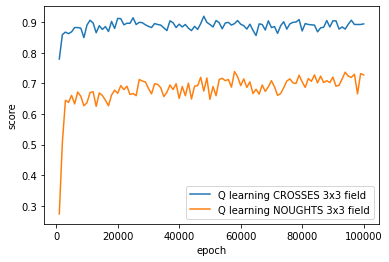

In [ ]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'Q learning CROSSES 3x3 field')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'Q learning NOUGHTS 3x3 field')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend();

# 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [ ]:
env = TicTacToe(4,4,4)
Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, env = env, n_games = 100000, verbose = False, crosses = 1)
Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, env = env, n_games = 100000, verbose = False, crosses = -1)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

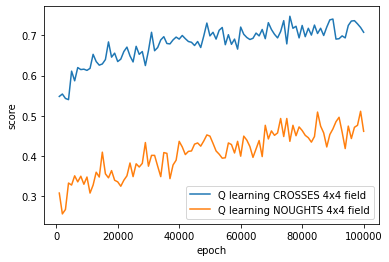

In [ ]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'Q learning CROSSES 4x4 field')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'Q learning NOUGHTS 4x4 field')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend();

# Часть вторая: добавим нейронных сетей


## 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. 

In [ ]:
Capcity = 10000
N_games = 10000
n_chanels = 9
batch_size = 64
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    def __init__(self, field_size):
        super(DQN, self).__init__()
        self.field_size = field_size
        
        self.conv = nn.Conv2d(1, self.field_size * self.field_size, kernel_size = self.field_size)
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class DQN_noughts(nn.Module):
    def __init__(self, field_size, n_chanels):
        super(DQN_noughts, self).__init__()
        self.field_size = field_size
        self.n_chanels = n_chanels
        
        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size = self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
    def forward(self, x):
        x = F.relu(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)
        x = self.l(x)
        return x

In [ ]:
def e_greedy_dqn(env, dqn, epsilon = 0.01, device = device):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    fstate = torch.Tensor(env.board)
    actions = dqn(fstate.unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).cpu().detach().numpy()
    Q_actions = actions[possible_actions] 
    if np.random.random() > epsilon:
        return possible_actions[np.argmax(Q_actions)]
    else:
        return np.random.choice(possible_actions)

In [ ]:
def dqn_learn(dqn, memory, optimizer, gamma):
    batch = memory.sample(batch_size)
    
    fstate_batch = [el[0] for el in batch]
    
    actions = np.array([el[1] for el in batch])
    
    fnext_state_batch = [el[2][0] for el in batch]
    isTermanal = [el[2][1] for el in batch]
    fnext_actions = [el[2][2] for el in batch]
    
    reward = np.array([el[3] for el in batch])
    
    with torch.no_grad():
        predictions = dqn(torch.Tensor(fnext_state_batch).unsqueeze(1).to(device)).cpu().detach().numpy()
        predicted_target = gamma * np.array(
            [np.max(predictions[i][fnext_actions[i]]) if fnext_actions[i] != [] else 0. for i in range(batch_size)])
        predicted_target += reward
        target = torch.Tensor([reward[i] if isTermanal[i] else predicted_target[i] for i in range(batch_size)])
    
    predictions = dqn(torch.Tensor(fstate_batch).unsqueeze(1).to(device)).cpu().squeeze()

    loss = F.mse_loss(predictions[np.arange(batch_size), actions], target)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [ ]:
def DQN_train_episode(env, NN, optimizer, memory, gamma = 1., crosses = 1, Capcity = Capcity, device = device, *args, **kwargs):
    env.reset()

    if env.curTurn != crosses:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    loss = 0.
    
    while True:

        fstate = env.board
        fstate_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        
        action = e_greedy_dqn(env, NN, *args, **kwargs)

        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = crosses * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss

        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
            
        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = crosses * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss
        else:
            fnext_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            memory.push(fstate, action, (env.board, not done, fnext_actions), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)

In [ ]:
def DQN_train(env, NN, N_games = N_games, gamma = 1., crosses = 1, Capcity = Capcity, device = device, verbose = True, print_every = 1000,  *args, **kwargs):
    memory = ReplayMemory(Capcity)
    optimizer = optim.Adam(NN.parameters(), 0.01)
    
    mean_game_rewards = []
    mean_game_loss = []
    avg_every = []
    loss_every = []
    epsilon = 1.
    for i in tqdm_notebook(range(N_games)):
        if i % 1000 == 999:
            epsilon = epsilon - 0.1
            epsilon = max(0.01, epsilon)
        R, loss = DQN_train_episode(env, NN, optimizer, memory, gamma, crosses, Capcity, device, epsilon= epsilon,*args, **kwargs)
        avg_every.append(R)
        loss_every.append(loss)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, N_games) + " avg rewards: {}".format(np.mean(avg_every)) + ' avg loss: {}'.format(np.mean(loss_every)))
            mean_game_rewards.append(np.mean(avg_every))
            mean_game_loss.append(np.mean(loss_every))
            avg_every = []
            loss_every = []
    return NN, mean_game_rewards

### 3x3

In [ ]:
env = TicTacToe(3,3,3)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  from ipykernel import kernelapp as app


1000/10000 avg rewards: 0.286 avg loss: 0.6317843969613314
2000/10000 avg rewards: 0.346 avg loss: 0.6675814174190163
3000/10000 avg rewards: 0.361 avg loss: 0.668526214428246
4000/10000 avg rewards: 0.295 avg loss: 0.6559335637688637
5000/10000 avg rewards: 0.413 avg loss: 0.6278577561378479
6000/10000 avg rewards: 0.469 avg loss: 0.5968002855032682
7000/10000 avg rewards: 0.485 avg loss: 0.566501519702375
8000/10000 avg rewards: 0.523 avg loss: 0.5271064638905227
9000/10000 avg rewards: 0.663 avg loss: 0.5002978764139115
10000/10000 avg rewards: 0.756 avg loss: 0.4508933421894908


In [ ]:
env = TicTacToe(3,3,3)
NN_noughts = DQN_noughts(env.n_cols, 64).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 avg rewards: -0.276 avg loss: 0.3934311094172299
2000/10000 avg rewards: -0.258 avg loss: 0.5467859874814749
3000/10000 avg rewards: -0.218 avg loss: 0.5706852827742696
4000/10000 avg rewards: -0.201 avg loss: 0.5659878387674689
5000/10000 avg rewards: -0.207 avg loss: 0.5589847554191947
6000/10000 avg rewards: -0.183 avg loss: 0.5409673605635762
7000/10000 avg rewards: -0.099 avg loss: 0.5370676891952753
8000/10000 avg rewards: -0.101 avg loss: 0.500254148542881
9000/10000 avg rewards: 0.108 avg loss: 0.45349879045784475
10000/10000 avg rewards: 0.019 avg loss: 0.38577859042957424


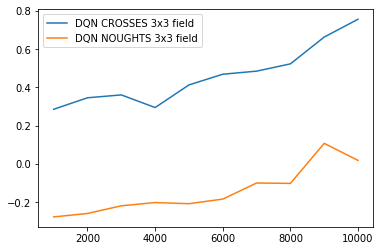

In [ ]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'DQN CROSSES 3x3 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'DQN NOUGHTS 3x3 field')
plt.legend()

### 4x4

In [ ]:
env = TicTacToe(4,4,4)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 avg rewards: 0.047 avg loss: 0.5592663183705882
2000/10000 avg rewards: 0.042 avg loss: 0.597163393503055
3000/10000 avg rewards: 0.092 avg loss: 0.583614156216383
4000/10000 avg rewards: 0.057 avg loss: 0.5898515648860484
5000/10000 avg rewards: 0.139 avg loss: 0.5854194870190695
6000/10000 avg rewards: 0.156 avg loss: 0.5879119742391631
7000/10000 avg rewards: 0.203 avg loss: 0.5721562898587436
8000/10000 avg rewards: 0.282 avg loss: 0.5805408842749894
9000/10000 avg rewards: 0.377 avg loss: 0.5705125480219722
10000/10000 avg rewards: 0.459 avg loss: 0.5806815658472478


In [ ]:
env = TicTacToe(4,4,4)
NN_noughts = DQN_noughts(env.n_cols, 128).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 avg rewards: -0.024 avg loss: 0.22625820476707303
2000/10000 avg rewards: -0.063 avg loss: 0.4529950941062998
3000/10000 avg rewards: 0.027 avg loss: 0.47615025624562984
4000/10000 avg rewards: 0.08 avg loss: 0.4719880168649834
5000/10000 avg rewards: 0.084 avg loss: 0.504997004095465
6000/10000 avg rewards: 0.112 avg loss: 0.5296239451989532
7000/10000 avg rewards: 0.171 avg loss: 0.5424643273726105
8000/10000 avg rewards: 0.275 avg loss: 0.5492539221271873
9000/10000 avg rewards: 0.306 avg loss: 0.5651385610643774
10000/10000 avg rewards: 0.321 avg loss: 0.5487641058573499


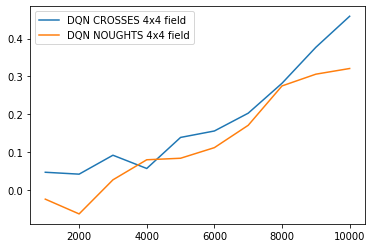

In [ ]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'DQN CROSSES 4x4 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'DQN NOUGHTS 4x4 field')
plt.legend()

## 4. Реализуйте Double DQN и/или Dueling DQN.

In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, field_size, n_chanels):
        super(DuelingDQN, self).__init__()
        self.field_size = field_size
        self.n_chanels = n_chanels
        
        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size = self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
        self.l2 = nn.Linear(self.n_chanels, 1)
    def forward(self, x):
        x = torch.tanh(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)
        
        z = self.l(x)
        y = self.l2(x)
        ma =  torch.mean(z, dim=1, keepdim=True)
        #https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751
        return z + y - ma

In [ ]:
env = TicTacToe(3,3,3)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 avg rewards: 0.295 avg loss: 0.5341331740710884
2000/10000 avg rewards: 0.283 avg loss: 0.6262141818106175
3000/10000 avg rewards: 0.394 avg loss: 0.6601021127551794
4000/10000 avg rewards: 0.374 avg loss: 0.6531158558726311
5000/10000 avg rewards: 0.404 avg loss: 0.6336426898762584
6000/10000 avg rewards: 0.432 avg loss: 0.6214137168303132
7000/10000 avg rewards: 0.365 avg loss: 0.6173937738239765
8000/10000 avg rewards: 0.332 avg loss: 0.6092796445190907
9000/10000 avg rewards: 0.387 avg loss: 0.5861480666622519
10000/10000 avg rewards: 0.519 avg loss: 0.5735171833038331


In [ ]:
env = TicTacToe(3,3,3)
NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 avg rewards: -0.25 avg loss: 0.4712136089652777
2000/10000 avg rewards: -0.305 avg loss: 0.5975768149122596
3000/10000 avg rewards: -0.29 avg loss: 0.6309390882179141
4000/10000 avg rewards: -0.284 avg loss: 0.6431455792859196
5000/10000 avg rewards: -0.204 avg loss: 0.6461975047066808
6000/10000 avg rewards: -0.098 avg loss: 0.6219959545210004
7000/10000 avg rewards: 0.035 avg loss: 0.6154583424627781
8000/10000 avg rewards: 0.025 avg loss: 0.5960957504287362
9000/10000 avg rewards: -0.073 avg loss: 0.5989221882447601
10000/10000 avg rewards: -0.285 avg loss: 0.6186135409101844


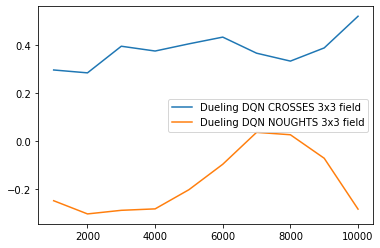

In [ ]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'Dueling DQN CROSSES 3x3 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'Dueling DQN NOUGHTS 3x3 field')
plt.legend()

In [ ]:
env = TicTacToe(4,4,4)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 avg rewards: 0.01 avg loss: 0.4509780177301727
2000/10000 avg rewards: 0.039 avg loss: 0.5638001253306866
3000/10000 avg rewards: 0.09 avg loss: 0.5703347560111434
4000/10000 avg rewards: 0.07 avg loss: 0.5813182934187353
5000/10000 avg rewards: 0.105 avg loss: 0.5915912211230024
6000/10000 avg rewards: 0.192 avg loss: 0.6314275752417743
7000/10000 avg rewards: 0.116 avg loss: 0.6488531970325857
8000/10000 avg rewards: 0.103 avg loss: 0.6014384109685198
9000/10000 avg rewards: 0.17 avg loss: 0.60438836243283
10000/10000 avg rewards: 0.245 avg loss: 0.6391910264156759


In [ ]:
env = TicTacToe(4,4,4)
NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1000/10000 avg rewards: -0.036 avg loss: 0.4393658609138802
2000/10000 avg rewards: -0.014 avg loss: 0.573680797321722
3000/10000 avg rewards: 0.0 avg loss: 0.5728004072755575
4000/10000 avg rewards: -0.056 avg loss: 0.5871637543132529
5000/10000 avg rewards: 0.042 avg loss: 0.587151179080829
6000/10000 avg rewards: 0.019 avg loss: 0.5688879608307034
7000/10000 avg rewards: 0.046 avg loss: 0.5261047277422621
8000/10000 avg rewards: 0.096 avg loss: 0.5232692644512281
9000/10000 avg rewards: 0.068 avg loss: 0.5562453293893487
10000/10000 avg rewards: 0.101 avg loss: 0.5446584154516458


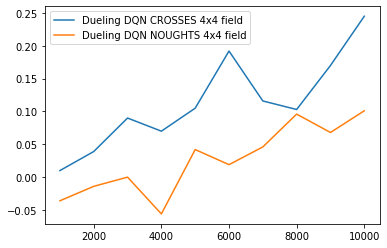

In [ ]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'Dueling DQN CROSSES 4x4 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'Dueling DQN NOUGHTS 4x4 field')
plt.legend()

# Часть третья: расширим и углубим поиск

## 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте). 

In [ ]:
def rollout(env, strategy, nrolls, crosses, *args, **kwargs):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    rewards = {el: [] for el in possible_actions}
    for i in range(nrolls):
        for act in possible_actions:
            cur_env = deepcopy(env)
            _, reward, done, _ = cur_env.step(cur_env.action_from_int(act))
            if done:
                rewards[act].append(reward * crosses)
                continue
                
            while True:
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                opponents_action = np.random.choice(p_actions)
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
                if done:
                    rewards[act].append(reward * crosses)
                    break
                
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                our_action = strategy(cur_env, *args, **kwargs)
                
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
                if done:
                    rewards[act].append(reward * crosses)
                    break
                    
    actions = {el: np.mean(rewards[el]) for el in possible_actions}
    maxi = -10
    max_act = 0
    for act in actions.keys():
        if actions[act] > maxi:
            max_act = act
            maxi = actions[act]
    return max_act, actions

In [ ]:
def rollout_game(env, strategy, nrolls = 100, crosses = 1, *args, **kwargs):
    if crosses != env.curTurn:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    
    while True:
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        our_action, _ = rollout(env, strategy, nrolls, crosses, *args, **kwargs)
                
        _, reward, done, _ = env.step(env.action_from_int(our_action))
        
        if done:
            return reward * crosses
        
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        
        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        
        if done:
            return reward * crosses

In [ ]:
def random_str(env):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    return possible_actions[np.random.choice(len(possible_actions))]

In [ ]:
env = TicTacToe(3,3,3)
env.reset()

In [ ]:
rewards = []
for i in tqdm_notebook(range(100)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 100))
    
print(np.mean(rewards))

  0%|          | 0/100 [00:00<?, ?it/s]

0.97


In [ ]:
rewards = []
for i in tqdm_notebook(range(100)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 100, crosses = -1))
    
print(np.mean(rewards))

  0%|          | 0/100 [00:00<?, ?it/s]

0.87


In [ ]:
env = TicTacToe(4,4,4)
env.reset()

In [ ]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20))
    
print(np.mean(rewards))

  0%|          | 0/20 [00:00<?, ?it/s]

1.0


In [ ]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20, crosses = -1))
    
print(np.mean(rewards))

  0%|          | 0/20 [00:00<?, ?it/s]

0.8


## 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [ ]:
def replace(s, position, character):
    return s[:position] + character + s[position+1:]

In [ ]:
C = 0.8

class Node():
    def __init__(self):
        self.parent = None
        self.children = {}
        self.visits = 0
        self.value = 0
        self.state = None
        self.index = 0
        self.storage = None
    
    def ucb(self):
        if self.visits == 0:
            return float('inf')
        return self.value / self.visits + C * math.sqrt(math.log(self.storage[self.parent].visits) / self.visits)
    
    def create_children(self):
        if self.is_leaf():
            np_state = np.array(list(map(int, self.state)))
            available_actions = np.where(np_state == 1)[0]
            if (len(self.state) - len(available_actions)) % 2 == 0:
                curTurn = 1
            else:
                curTurn = -1
            for action in available_actions:
                child = Node()
                child.parent = self.index
                child.state = replace(self.state, action, str(curTurn + 1))
                child.index = len(self.storage)
                child.storage = self.storage
                self.children[action] = child.index
                self.storage.append(child)
    
    def is_leaf(self):
        return len(self.children) == 0
    
    def select_child(self, how="best"):
        eps = 0.7
        if how == "best":
            fun = max
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "worse":
            fun = min
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "random":
            return random.choice(list(self.children.items()))
        else:
            fun = None
            characteristic = None
        if not self.is_leaf():
            return max(self.children.items(), key=characteristic)

In [ ]:
 def rollout(env, strategy, nrolls, crosses, *args, **kwargs):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    cur_env= deepcopy(env)
    done = env.gameOver
    if done:
        return 0 
    
    while True:
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        our_action = strategy(cur_env, *args, **kwargs)
                
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
        if done:
            return reward * crosses
        
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
        if done:
            return reward * crosses
                

In [ ]:
class Mcts():
    def __init__(self, env, crosses = 1):
        self.env = env
        self.env.reset()
        self.crosses = crosses
        self.nodes = []

        root = Node()
        root.state = self.env.getState()[0]
        root.index = 0
        root.storage = self.nodes
        self.nodes.append(root)
        
        self.current_node = 0
        
    def next_step(self):
        action, self.current_node = self.nodes[self.current_node].select_child()
        self.env.step(self.env.action_from_int(action))
    
    def selection(self):
        while not self.nodes[self.current_node].is_leaf():
            self.next_step()
    
    def expansion(self):
        if not self.env.gameOver:
            if self.nodes[self.current_node].visits > 0:
                self.nodes[self.current_node].create_children()
                self.next_step()
    
    def simulation(self):
        return rollout(self.env, random_str, 1, self.crosses)
    
    def backpropagation(self, r):
        while self.nodes[self.current_node].parent is not None:
            self.nodes[self.current_node].visits += 1
            self.nodes[self.current_node].value += r
            self.current_node = self.nodes[self.current_node].parent
        self.nodes[self.current_node].visits += 1
        self.nodes[self.current_node].value += r
    
    def learn(self, n_episodes=10000):
        for _ in tqdm_notebook(range(n_episodes)):
            assert self.current_node == 0
            self.env.reset()
            self.selection()
            self.expansion()
            r = self.simulation()
            self.backpropagation(r)

In [ ]:
def run(model, n_episodes = 12, crosses = 1):
    cum_rewards = 0
    count_games = 0
    for _ in range(n_episodes):
        model.env.reset()
        model.current_node = 0
        if crosses == 1:
            hows = [None, "best", "random"]
        elif crosses == -1:
            hows = [None, "random", "worse"]
        else:
            hows = None
        while not model.nodes[model.current_node].is_leaf():
            action, model.current_node = model.nodes[model.current_node].select_child(hows[model.env.curTurn])
            _, reward, done, _ = model.env.step(model.env.action_from_int(action))
        if done:
            cum_rewards += reward
            count_games += 1
    mean_reward = cum_rewards / count_games
    print(f"Mean reward vs random policy equal {mean_reward} after {count_games} games.")
    return mean_reward

In [50]:
env = TicTacToe(3,3,3)

mcts = Mcts(env, 1000000)
mcts.learn()
run(mcts, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Mean reward vs random policy equal 0.410146173688736 after 1163 games.


0.410146173688736

In [52]:
env = TicTacToe(4,4,4)

mcts = Mcts(env, 10000000)
mcts.learn()
run(mcts, 100000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Mean reward vs random policy equal 1.0 after 4 games.


1.0